In [35]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

In [36]:
## url das bases de dados
url_adult_train = 'http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
url_adult_test = 'http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'

In [37]:
## lendo os dados em python
adult_train = pd.read_csv(url_adult_train, sep=',',header=None)
adult_test = pd.read_csv(url_adult_test, sep=',',skiprows=1,header=None)

In [38]:
## dados estão sem cabeçalho, temos que colocar as colunas nos dataframes
columns = ['age','workclass','fnlwgt','education','education_num','marital_status',
           'occupation','relationship','race','sex','capital_gain','capital_loss',
           'hours_per_week','country','income_higher_than_50k']

adult_train.columns = columns
adult_test.columns = columns

In [39]:
## Checando valores nulos 
colunas_categoricas = adult_train.select_dtypes('object').columns.tolist()
print(len(colunas_categoricas))

9


In [40]:
# retirando os valores ?
adult_train = adult_train.replace(' ?', np.NaN, inplace=False)
adult_test = adult_test.replace(' ?', np.NaN, inplace=False)

In [41]:
## calcular proporção de nulos
total = len(adult_train)
for columns in colunas_categoricas:
     nulos = adult_train[columns].isna().sum()
     proporcao = round(nulos/total,2) * 100
     print("o percentual de nulos da coluna", columns, "é de ", str(proporcao),'%')

o percentual de nulos da coluna workclass é de  6.0 %
o percentual de nulos da coluna education é de  0.0 %
o percentual de nulos da coluna marital_status é de  0.0 %
o percentual de nulos da coluna occupation é de  6.0 %
o percentual de nulos da coluna relationship é de  0.0 %
o percentual de nulos da coluna race é de  0.0 %
o percentual de nulos da coluna sex é de  0.0 %
o percentual de nulos da coluna country é de  2.0 %
o percentual de nulos da coluna income_higher_than_50k é de  0.0 %


In [42]:
## Conforme documentação do próprio site, a coluna fnlwgt não tem função descrição nenhuma.
## coluna education assim como a coluna education-num representam a mesma informação, vamos trabalhar com a coluna education-num e retirar a education
adult_train = adult_train.drop(['fnlwgt', 'education'], axis = 1)
adult_test = adult_test.drop(['fnlwgt', 'education'], axis = 1)

In [43]:
### Preprocessamento dos dados 
tree_adult_train = adult_train.copy()
tree_adult_test = adult_test.copy()

In [44]:
## determinando o valor de y que o se a pessoal tem um income > que 50k
## retirando o valor de y da base de treino
colunas_categoricas = adult_train.select_dtypes('object').columns.tolist()

In [45]:
from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()
for column in colunas_categoricas:
   tree_adult_train[column] = label.fit_transform(tree_adult_train[column])

In [46]:
## retirando o valor de y da base de treino
y = tree_adult_train['income_higher_than_50k']
tree_adult_train.drop(['income_higher_than_50k'], axis = 1, inplace = True)

In [47]:
from sklearn.model_selection import StratifiedKFold, train_test_split
## agora iremos alocar 30% do dados de treino para o houldout e 70% do dados de treino para base de treino
X_train, X_holdout, y_train, y_holdout = train_test_split(
    tree_adult_train, y, test_size=0.3, random_state=17
)

In [48]:
# criando o modelo
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [49]:
# importando library de métricas
from sklearn.metrics import accuracy_score

tree_pred = tree_clf.predict(X_holdout)

In [50]:
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print('Modelo de Decision tree para dados de Holdout')
print('Acuracia Holdout:', accuracy_score(tree_pred, y_holdout))
print('Precisão Holdout:', precision_score(tree_pred, y_holdout))
print('Revocacao Holdout:', recall_score(tree_pred, y_holdout))
print('f1_score Holdout:', f1_score(tree_pred, y_holdout))

Modelo de Decision tree para dados de Holdout
Acuracia Holdout: 0.8158460436073293
Precisão Holdout: 0.6134453781512605
Revocacao Holdout: 0.6241983753740915
f1_score Holdout: 0.6187751642297097


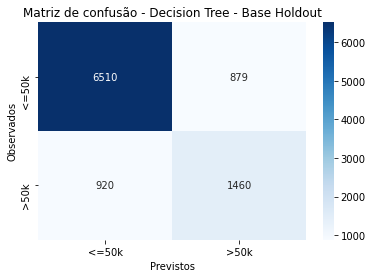

In [51]:
### Matriz de confusão
from sklearn.metrics import classification_report, confusion_matrix
cf_matrix_knn = confusion_matrix(y_holdout, tree_pred)
ax = sn.heatmap(cf_matrix_knn, annot=True, cmap='Blues', fmt='g')

ax.set_title('Matriz de confusão - Decision Tree - Base Holdout')
ax.set_xlabel('Previstos')
ax.set_ylabel('Observados')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['<=50k','>50k'])
ax.yaxis.set_ticklabels(['<=50k','>50k'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [52]:
### Tunando Hyperparamêtros da árvore de decisão
from sklearn.model_selection import GridSearchCV

params = {
    "criterion":("gini", "entropy"), 
    "splitter":("best", "random"), 
    "max_depth":(list(range(1, 15))), 
    "min_samples_split":[2, 3, 4], 
    "min_samples_leaf":list(range(1, 15)), 
}
tree_clf = DecisionTreeClassifier(random_state=42)

tree_cv = GridSearchCV(
    tree_clf, 
    params, 
    scoring="f1", 
    n_jobs=-1, 
    verbose=1, 
    cv=5
)

tree_cv.fit(X_train, y_train)
best_params = tree_cv.best_params_
print(f"Best paramters: {best_params})")

Fitting 5 folds for each of 2352 candidates, totalling 11760 fits
Best paramters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 6, 'min_samples_split': 2, 'splitter': 'best'})


In [53]:
## criando o modelo com os melhores parâmetros
tree_clf = DecisionTreeClassifier(**best_params)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_leaf=6)

In [54]:
tree_pred = tree_clf.predict(X_holdout)

In [55]:
print('Modelo de Decision tree para dados de Holdout após cross-validation')
print('Acuracia Holdout:', accuracy_score(tree_pred, y_holdout))
print('Precisão Holdout:', precision_score(tree_pred, y_holdout))
print('Revocacao Holdout:', recall_score(tree_pred, y_holdout))
print('f1_score Holdout:', f1_score(tree_pred, y_holdout))

Modelo de Decision tree para dados de Holdout após cross-validation
Acuracia Holdout: 0.8529020370559934
Precisão Holdout: 0.6457983193277311
Revocacao Holdout: 0.7212576255279212
f1_score Holdout: 0.6814453557969409


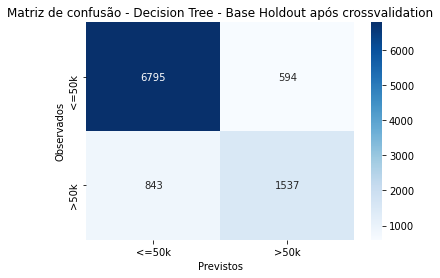

In [56]:
### Matriz de confusão
from sklearn.metrics import classification_report, confusion_matrix
cf_matrix_knn = confusion_matrix(y_holdout, tree_pred)
ax = sn.heatmap(cf_matrix_knn, annot=True, cmap='Blues', fmt='g')

ax.set_title('Matriz de confusão - Decision Tree - Base Holdout após crossvalidation')
ax.set_xlabel('Previstos')
ax.set_ylabel('Observados')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['<=50k','>50k'])
ax.yaxis.set_ticklabels(['<=50k','>50k'])

## Display the visualization of the Confusion Matrix.
plt.show()

## Para os dados de teste

In [57]:
for column in colunas_categoricas:
   tree_adult_test[column] = label.fit_transform(tree_adult_test[column])

In [58]:
## retirando o valor de y da base de Teste
y_teste = tree_adult_test['income_higher_than_50k']
tree_adult_test.drop(['income_higher_than_50k'], axis = 1, inplace = True)

In [59]:
X_teste = tree_adult_test.copy()

In [60]:
y_hat = tree_clf.predict(X_teste)

In [61]:
print('Modelo de Decision tree para dados de teste')
print('Acuracia teste:', accuracy_score(y_hat, y_teste))
print('Precisão teste:', precision_score(y_hat, y_teste))
print('Revocacao teste:', recall_score(y_hat, y_teste))
print('f1_score teste:', f1_score(y_hat, y_teste))

Modelo de Decision tree para dados de teste
Acuracia teste: 0.8563970272096308
Precisão teste: 0.6437857514300572
Revocacao teste: 0.718931475029036
f1_score teste: 0.6792866941015089


In [63]:
import sklearn.tree as tree
text_representation = tree.export_text(tree_clf)
print(text_representation)

|--- feature_5 <= 0.50
|   |--- feature_8 <= 5095.50
|   |   |--- feature_2 <= 12.50
|   |   |   |--- feature_2 <= 8.50
|   |   |   |   |--- feature_9 <= 1791.50
|   |   |   |   |   |--- feature_10 <= 49.50
|   |   |   |   |   |   |--- feature_2 <= 5.50
|   |   |   |   |   |   |   |--- feature_0 <= 37.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- feature_0 >  37.50
|   |   |   |   |   |   |   |   |--- feature_0 <= 66.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- feature_0 >  66.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- feature_2 >  5.50
|   |   |   |   |   |   |   |--- feature_0 <= 36.50
|   |   |   |   |   |   |   |   |--- feature_2 <= 6.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- feature_2 >  6.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- feature_0 >  36.50
|   |   |   |   |   |  

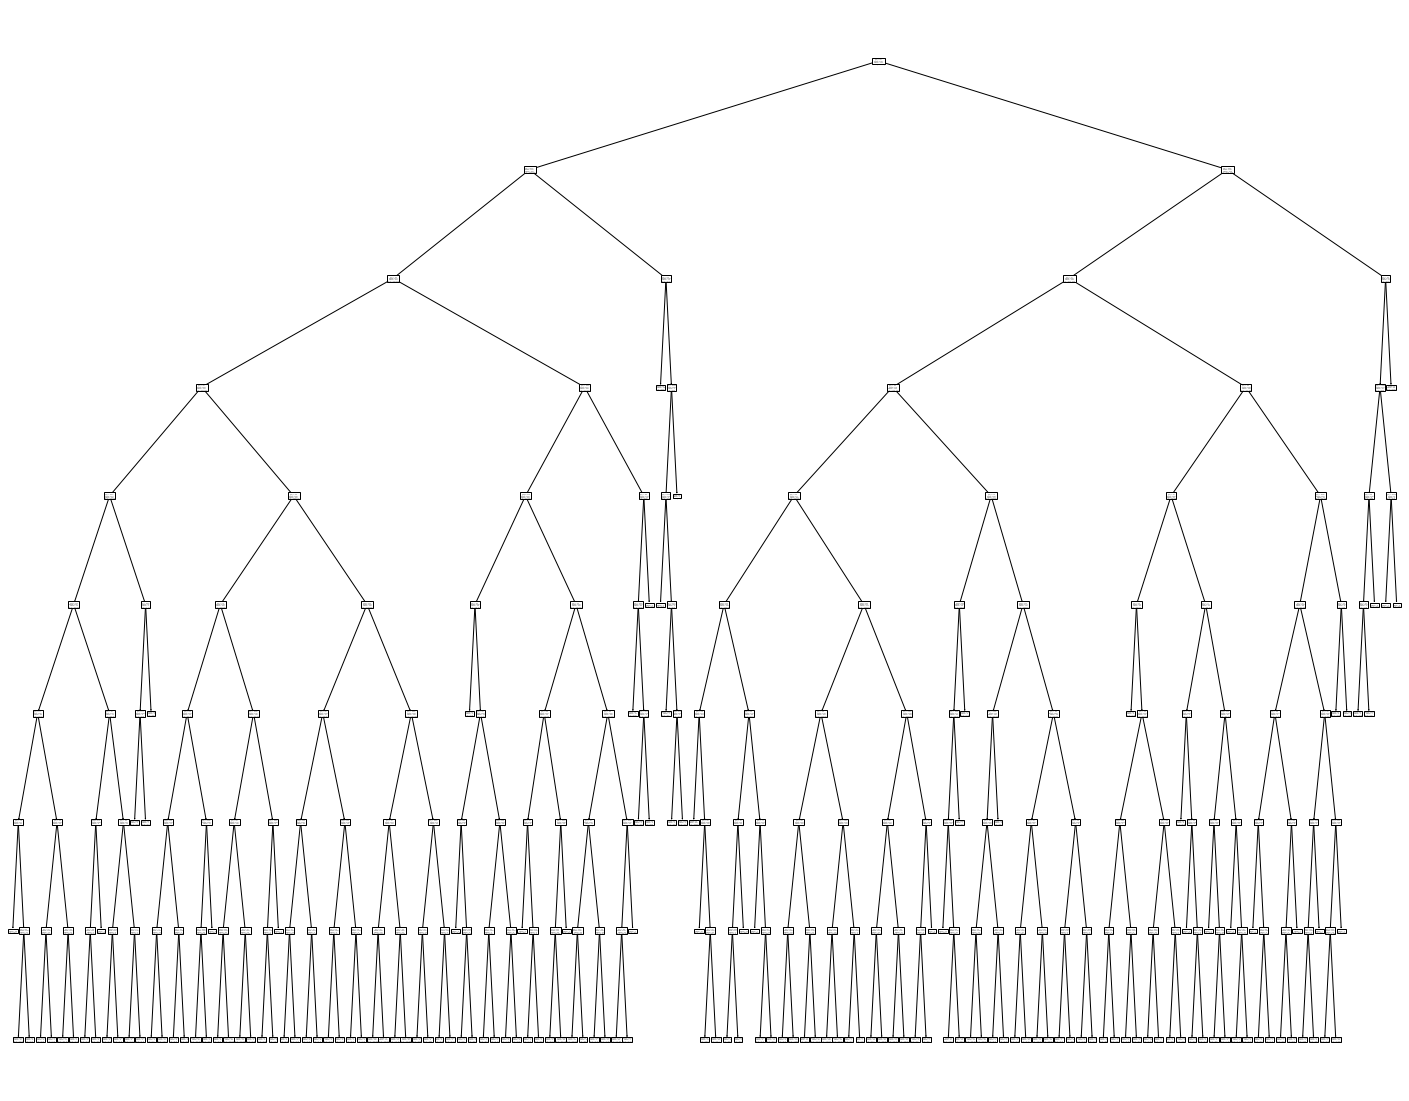

In [69]:
fig = plt.figure(figsize=(25,20))
tree.plot_tree(tree_clf)
plt.show()